## Load data

In [31]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras

In [32]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
datapath = '/media/sf_VBox_Shared/timeseries/PAMAP2_Dataset/slidingwindow512cleaned/'

In [34]:
ext = '.npy'
X_train = np.load(datapath+'X_train'+ext)
y_train_binary = np.load(datapath+'y_train_binary'+ext)
X_val = np.load(datapath+'X_val'+ext)
y_val_binary = np.load(datapath+'y_val_binary'+ext)
X_test = np.load(datapath+'X_test'+ext)
y_test_binary = np.load(datapath+'y_test_binary'+ext)

In [35]:
num_classes = y_train.shape[1]
print(num_classes)

12


## Generate models

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [37]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [38]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 3,
                                  model_type = 'CNN',
                                  max_layers=4
                                 )

CPU times: user 220 ms, sys: 0 ns, total: 220 ms
Wall time: 222 ms


In [39]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'regularization_rate': 0.026002310429751384, 'filters': array([61, 32]), 'fc_hidden_nodes': 95, 'learning_rate': 0.00010758432561136211}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_31 (Convolution1D) (None, 512, 61)       1708        convolution1d_input_8[0][0]      
____________________________________________________________________________________________________
convolution1d_32 (Convolution1D) (None, 512, 32)       5888        convolution1d_31[0][0]           
____________________________________________________________________________________________________
activation_47 (Activation)       (None, 512, 32)       0           convolution1d_32[0][0]           
____________________________________________________________________________________________________
flatten_8 (Flatten)              (None, 16384)        

## Compare models

In [40]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=5,
                                                                                  subsize_set=500,
                                                                                  verbose=True)

Train on 500 samples, validate on 2007 samples
Epoch 1/5
500/500 [==============================] - 9s - loss: 7.3838 - acc: 0.3660 - val_loss: 1.8718 - val_acc: 0.4694
Epoch 2/5
500/500 [==============================] - 8s - loss: 5.3813 - acc: 0.7500 - val_loss: 1.0434 - val_acc: 0.6572
Epoch 3/5
500/500 [==============================] - 9s - loss: 4.9004 - acc: 0.8380 - val_loss: 1.1669 - val_acc: 0.6233
Epoch 4/5
500/500 [==============================] - 8s - loss: 4.6582 - acc: 0.8700 - val_loss: 0.7764 - val_acc: 0.7758
Epoch 5/5
500/500 [==============================] - 10s - loss: 4.4163 - acc: 0.9300 - val_loss: 1.1526 - val_acc: 0.7080
Train on 500 samples, validate on 2007 samples
Epoch 1/5
500/500 [==============================] - 2s - loss: 13.4162 - acc: 0.1840 - val_loss: 13.4759 - val_acc: 0.1639
Epoch 2/5
500/500 [==============================] - 3s - loss: 13.8393 - acc: 0.2080 - val_loss: 13.4759 - val_acc: 0.1639
Epoch 3/5
500/500 [============================

CPU times: user 360 ms, sys: 8 ms, total: 368 ms
Wall time: 475 ms


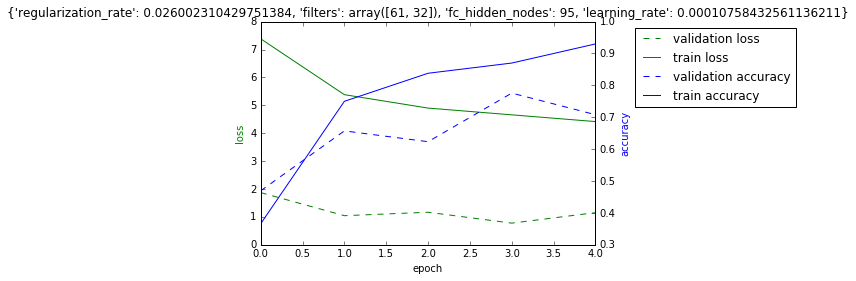

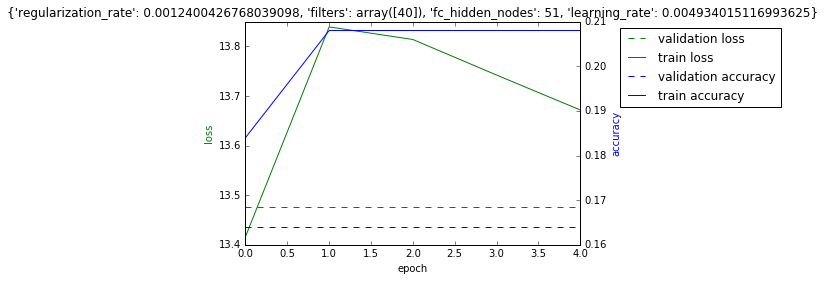

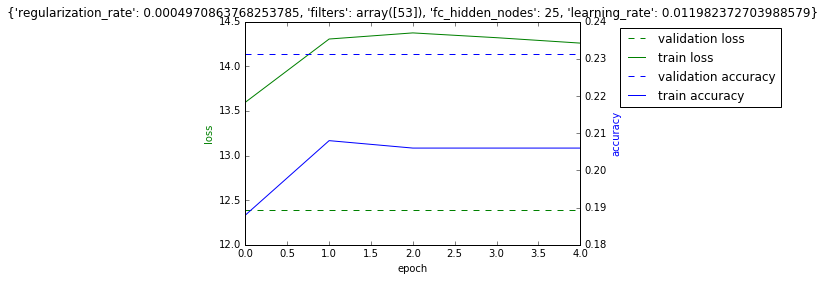

In [41]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [42]:
%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

CPU times: user 204 ms, sys: 40 ms, total: 244 ms
Wall time: 414 ms


In [43]:
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'regularization_rate': 0.026002310429751384, ...",0.930,4.416336,0.708022,1.152610
1,"{'regularization_rate': 0.0012400426768039098,...",0.208,13.671877,0.163926,13.475916
2,"{'regularization_rate': 0.0004970863768253785,...",0.206,14.259193,0.231191,12.391740


## Train the best model for real

In [44]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = 3

In [45]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'regularization_rate': 0.026002310429751384, 'filters': array([61, 32]), 'fc_hidden_nodes': 95, 'learning_rate': 0.00010758432561136211}


In [46]:
nr_epochs = 5 #10
datasize = X_train.shape[0]#1000
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

Train on 12497 samples, validate on 2007 samples
Epoch 1/5
12497/12497 [==============================] - 98s - loss: 4.0046 - acc: 0.8865 - val_loss: 0.2296 - val_acc: 0.9357
Epoch 2/5
12497/12497 [==============================] - 79s - loss: 3.0882 - acc: 0.9629 - val_loss: 0.1986 - val_acc: 0.9362
Epoch 3/5
12497/12497 [==============================] - 85s - loss: 2.5704 - acc: 0.9764 - val_loss: 0.1710 - val_acc: 0.9467
Epoch 4/5
12497/12497 [==============================] - 83s - loss: 2.1931 - acc: 0.9805 - val_loss: 0.1205 - val_acc: 0.9751
Epoch 5/5
12497/12497 [==============================] - 89s - loss: 1.9075 - acc: 0.9791 - val_loss: 0.2482 - val_acc: 0.9063


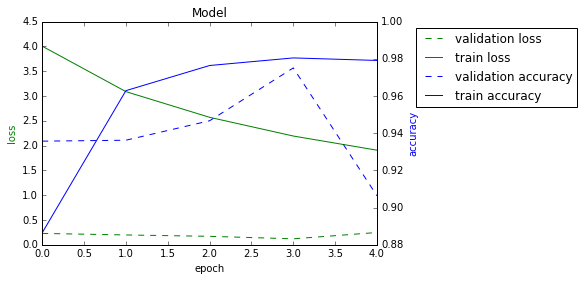

In [47]:
find_architecture.plotTrainingProcess(history)

## Inspect model predictions

In [48]:
datasize = X_val.shape[0]
probs = best_model.predict_proba(X_val[:datasize,:,:],batch_size=1)
probs

/home/dafne/anaconda2/envs/mcfly/lib/python3.5/site-packages/keras/backend/theano_backend.py:527: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


2007/2007 [==============================] - 27s    


array([[  9.99990642e-01,   9.37525056e-06,   2.51694022e-12, ...,
          1.00425742e-14,   1.02345378e-17,   1.05933506e-09],
       [  9.99989808e-01,   1.01921541e-05,   2.94893103e-12, ...,
          1.18587459e-14,   1.44862288e-17,   1.25317678e-09],
       [  9.99989867e-01,   1.01513924e-05,   2.91070857e-12, ...,
          1.27012904e-14,   1.68450104e-17,   1.41169076e-09],
       ..., 
       [  2.48973688e-17,   8.65132796e-19,   2.08912360e-21, ...,
          2.66699457e-17,   4.22602917e-27,   3.21322613e-13],
       [  7.70079898e-16,   4.32682958e-17,   4.29670665e-20, ...,
          6.16495593e-17,   1.67263965e-25,   1.91598348e-10],
       [  2.20852552e-13,   3.16070471e-15,   3.24790367e-21, ...,
          3.40585104e-14,   6.04260058e-25,   4.55533215e-11]])

In [49]:
best_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_31 (Convolution1D) (None, 512, 61)       1708        convolution1d_input_8[0][0]      
____________________________________________________________________________________________________
convolution1d_32 (Convolution1D) (None, 512, 32)       5888        convolution1d_31[0][0]           
____________________________________________________________________________________________________
activation_47 (Activation)       (None, 512, 32)       0           convolution1d_32[0][0]           
____________________________________________________________________________________________________
flatten_8 (Flatten)              (None, 16384)         0           activation_47[0][0]              
___________________________________________________________________________________________

In [50]:
score_test = best_model.evaluate(X_val, y_val_binary, verbose=True)
score_test

2007/2007 [==============================] - 5s     


[0.24818616381541089, 0.9063278525161933]

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

In [ ]:
best_model.get_config()[0]